## Precision and accuracy of eyetracking VSHD (Arrington ViewPoint)
### This notebook reads in a datafile made using the "Precision and Accuracy.sln" program, and prints out the precision and the accuracy of the measured gazes 
#### Imports libraries:

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

#### Presets:

In [2]:
#file to analyze
file = "C:/Users/Administrator/Documents/PrecisionAndAccuracy/second Measure Group/nikolai3.txt"

#Which eye to find accuracy and precision for ("A", "B", or "Average")
eye = "Average"

#### Function that calculates standard deviation of a list of 2D angles 

In [3]:
def calculateAngleStd(azimuthList, elevationList):
    azimuthList = azimuthList.reset_index(drop=True)
    elevationList = elevationList.reset_index(drop=True)
    
    
    meanAzimuth , meanElevation = azimuthList.mean(), elevationList.mean()
    meanAngle=(meanAzimuth, meanElevation)
    distanceList = []
    for i in range(len(azimuthList)):
        
        d = calculateDistance((azimuthList[i], elevationList[i]), meanAngle)

        distanceList.append(d)
    
    
    a=0
    for d in distanceList:
        a+=d**2
    std = math.sqrt(a/len(distanceList))
   
    
    
    return std

#### Function that calculates angular distance between two angles

In [4]:
def calculateDistance(a, b):
    AB = (a[0]-b[0], a[1] - b[1])

    d_AB = math.sqrt(AB[0]**2 + AB[1]**2)

    return d_AB

    

#### Function that calculates the precision of points in a DataFrame by measuring the distance between each point and their respective succesive points, then taking the root mean square (RMS) of these distances

In [5]:
def calculatePrecision(df): 
    gazePoints = []
    for i in range(len(df)):

        gazePoints.append((df["Azimuth"].reset_index(drop=True)[i], df["Elevation"].reset_index(drop=True)[i]))


    distanceList = []
    for i in range(len(gazePoints)-1):
        d = calculateDistance(gazePoints[i], gazePoints[i+1])

        distanceList.append(d)

    a=0
    for d in distanceList:
        a+=d**2
    precision = math.sqrt(a/len(distanceList))
    
    return precision


#### This function extracts gaze data from all of the data measured for each of the points shown on the screens
It finds the 18 succesive datapoints (300ms) in the data with the lowest standard deviation, and tries to extend the data one sample at a time in each direction until the standard deviation gets worse.

In [6]:
def getGazeData(df):  
    dropStart = 18
    
    angleData = df[["ATT","AverageABX","AverageABY","Azimuth","Elevation"]][dropStart:].reset_index(drop=True)

    gazeData = angleData[:18]

    for i in range(len(df)-17-dropStart):
        newGazeData = angleData[i:i+18] 
        if calculateAngleStd(gazeData["Azimuth"], gazeData["Elevation"]) > calculateAngleStd(newGazeData["Azimuth"], newGazeData["Elevation"]):
            gazeData = newGazeData
    
    
    
    
    #Tries to extend
        
    x=0
    while True:
        
        indexToAdd = gazeData.index[-1] + 1
        
        
        if indexToAdd in angleData.index:
            extGazeData = gazeData.append(angleData.iloc[indexToAdd]).sort_index()
        else:
            break
        
        if calculateAngleStd(gazeData["Azimuth"], gazeData["Elevation"]) > calculateAngleStd(extGazeData["Azimuth"], extGazeData["Elevation"]):
            gazeData = extGazeData
        else:
            break
        x+=1
        if x > 160:
            break
    
    while True:
        
        indexToAdd = gazeData.index[0] -1
        
       
        if indexToAdd in angleData.index:
            extGazeData = gazeData.append(angleData.iloc[indexToAdd]).sort_index()
        else:
            break

        if calculateAngleStd(gazeData["Azimuth"], gazeData["Elevation"]) > calculateAngleStd(extGazeData["Azimuth"], extGazeData["Elevation"]):
            gazeData = extGazeData
        else:
            break
        x+=1
        if x > 160:
            break
    return gazeData
    

#### Function that converts screen coordinates into gaze angle
Middle of screen is gaze angle = 0 and x=0.5 y=0.5

In [7]:
def calculateAngle(screenX, screenY, fovHorizontal=52.1, fovVertical=34):
    x = (screenX*2) - 1
    y = (screenY*2) - 1

    azimuth = math.atan(x*math.tan(fovHorizontal*math.pi/360))
    elevation = math.atan(y*math.tan(fovVertical*math.pi/360))

    
    return azimuth*180/math.pi, elevation*180/math.pi

    



#This function assumes a linear relationship between screen coordinates and gaze angle, and should therefore be less accurate than the above function
def calculateAngle2(screenX, screenY, fovHorizontal=52.1, fovVertical=34):
    x = (screenX*2) - 1
    y = (screenY*2) - 1

    azimuth = x*fovHorizontal/2
    elevation = y*fovVertical/2

    
    return azimuth, elevation

print(calculateAngle(0.84,0.81))


(18.38644820009973, 10.733247445709274)


#### Sets list of the true point values for comparison later

In [8]:
truePointValues = [(0.30, 0.75),(0.70, 0.25),(0.30, 0.25),(0.70, 0.75),(0.40, 0.60),(0.60, 0.60),(0.40, 0.40),(0.60, 0.40),(0.50, 0.425),(0.50, 0.75),(0.50, 0.25),(0.30, 0.50),(0.50, 0.35),(0.70, 0.50),(0.50, 0.65),(0.50, 0.50)]
truePointAngles = []

for point in truePointValues:
    angle = calculateAngle(point[0], point[1])
    truePointAngles.append(angle)
print(truePointAngles)

[(-11.06320230741821, 8.691257073883165), (11.063202307418205, -8.691257073883165), (-11.06320230741821, -8.691257073883165), (11.063202307418205, 8.691257073883165), (-5.583644357117053, 3.4990590634325542), (5.583644357117053, 3.4990590634325542), (-5.583644357117053, -3.4990590634325542), (5.583644357117053, -3.4990590634325542), (0.0, -2.6257219671274514), (0.0, 8.691257073883165), (0.0, -8.691257073883165), (-11.06320230741821, 0.0), (0.0, -5.240461161882563), (11.063202307418205, 0.0), (0.0, 5.240461161882563), (0.0, 0.0)]


#### Reads in the datafile and converts from txt into dataframe, drops all columns that are not relevant for our purposes.

In [9]:
with open(file) as rawData: 
    lineNumber = 0
    stimulusPointNr = 0
    unwantedLabels = ["6","ADT", "ACX", "ACY","ARI", "APW", "APH","AQU","AFX","BDT","BCX","BCY","BRI","BPW","BPH","BQU","BFX","GPX","GPY","GPZ","CNT"]
    
    
    dropFirstRows = list(range(0,60))
    
    
   

    for line in rawData:
        splittedLine =line.split()
        

        #If index of raw data is 6 it adds as rows
        if splittedLine[0] == "6":
            splittedLine.pop(27) #pops mrk label
            DfColumns = splittedLine
            formattedData = pd.DataFrame(columns=splittedLine)

            #Defines dataframes for measured data for all the stimulus points
            point1 = pd.DataFrame(columns=DfColumns)
            point2 = pd.DataFrame(columns=DfColumns)
            point3 = pd.DataFrame(columns=DfColumns)
            point4 = pd.DataFrame(columns=DfColumns)
            point5 = pd.DataFrame(columns=DfColumns)
            point6 = pd.DataFrame(columns=DfColumns)
            point7 = pd.DataFrame(columns=DfColumns)
            point8 = pd.DataFrame(columns=DfColumns)
            point9 = pd.DataFrame(columns=DfColumns)
            point10 = pd.DataFrame(columns=DfColumns)
            point11= pd.DataFrame(columns=DfColumns)
            point12 = pd.DataFrame(columns=DfColumns)
            point13 = pd.DataFrame(columns=DfColumns)
            point14 = pd.DataFrame(columns=DfColumns)
            point15 = pd.DataFrame(columns=DfColumns)
            point16 = pd.DataFrame(columns=DfColumns)
            
            stimulusPointData = [point1, point2, point3, point4, point5, point6, point7, point8, point9, point10, point11, point12, point13, point14, point15, point16]
        
        elif splittedLine[0] == "16":
            
            if splittedLine[1][0]=="0":
                print(splittedLine)
            #if stimulusPointNr >= 0: #Does so that it doesnt start appending the first lines to the last dataframe
            else:
                currentPointData = stimulusPointData[stimulusPointNr]
                stimulusPointNr +=1
           
            
            
        #All rows of data have index 10 in the raw data, some have marks though and are therefore 1 column longer,
        #this checks if length is 28 or 27. If its 28, pop last element and append to DF otherwise just append to DF.
        elif splittedLine[0] == "10":
            try: 
                splittedLine.pop(27)
                currentPointData.loc[len(currentPointData.index)] = splittedLine
            except IndexError:
                try:
                    currentPointData.loc[len(currentPointData.index)] = splittedLine
                except NameError:
                    pass
            except NameError:
                pass
          

   
    #Adds averagegaze-columns (both eyes), and removes unneccesary columns
i=0
   
for df in stimulusPointData:

    for label in unwantedLabels:
        df.pop(label)
        df=df.astype(float)
    #df=df.drop(labels=dropFirstRows, axis=0) #deletes first second because of reaction time induced error
    df["AverageABX"]=df[["ALX","BLX"]].mean(axis=1, numeric_only=True)
    df["AverageABY"]=df[["ALY","BLY"]].mean(axis=1, numeric_only=True)

    #df["ALX"]#
    #df["ALY"]#
    

    azimuthList = []
    elevationList = []

    for index in range(len(df["AverageABX"])):
        if eye == "Average":
            azimuth, elevation = calculateAngle(df["AverageABX"][index], df["AverageABY"][index])
        elif eye == "A":
            azimuth, elevation = calculateAngle(df["ALX"][index], df["ALY"][index])
        elif eye == "B":
            azimuth, elevation = calculateAngle(df["BLX"][index], df["BLY"][index])
        else:
            print("Error invalid eye")

        azimuthList.append(azimuth)
        elevationList.append(elevation)

    df["Azimuth"] = azimuthList
    df["Elevation"] = elevationList
    
    stimulusPointData[i] = df
    i+=1

stimulusPointData[0]

   
    



    



        
       
        



['16', '0.000000', 'C:\\Users\\Administrator\\Documents\\PrecisionAndAccuracy\\StimulusPoints_bmp\\16_96.bmp']


,ATT,ALX,ALY,BTT,BLX,BLY,AverageABX,AverageABY,Azimuth,Elevation
0,7.1406,0.5107,0.5613,7.1394,0.5290,0.5637,0.51985,0.56250,1.111736,2.188570
1,7.1432,0.5105,0.5692,7.1394,0.5290,0.5637,0.51975,0.56645,1.106137,2.326740
2,7.1738,0.5062,0.5561,7.1729,0.5283,0.5586,0.51725,0.55735,0.966148,2.008386
3,7.1775,0.5100,0.5662,7.1729,0.5283,0.5586,0.51915,0.56240,1.072540,2.185071
4,7.2075,0.5051,0.5552,7.2067,0.5293,0.5591,0.51720,0.55715,0.963348,2.001388
...,...,...,...,...,...,...,...,...,...,...
177,10.0803,0.3208,0.8356,10.0765,0.3140,0.8311,0.31740,0.83335,-10.121517,11.520814
178,10.1102,0.3234,0.8324,10.1099,0.3178,0.8362,0.32060,0.83430,-9.947715,11.552766
179,10.1151,0.3222,0.8412,10.1099,0.3178,0.8362,0.32000,0.83870,-9.980317,11.700655
180,10.1441,0.3209,0.8174,10.1396,0.3182,0.8297,0.31955,0.82355,-10.004764,11.190792


#### Makes a list of the 16 gaze DataFrames

In [10]:
gazeDataList = list(stimulusPointData)

#print(stimulusPointData)

i=0
for df in stimulusPointData:
    #print(df)
    gazeDataList[i]=getGazeData(df)
    i+=1
    

gazeDataList[0]

,ATT,AverageABX,AverageABY,Azimuth,Elevation
125,9.5141,0.31855,0.82530,-10.059079,11.249780
126,9.5431,0.31760,0.82440,-10.110660,11.219446
127,9.5481,0.31985,0.82965,-9.988467,11.396304
128,9.5767,0.31605,0.81760,-10.194784,10.990052
129,9.5796,0.31800,0.82805,-10.088944,11.342428
130,9.6096,0.31545,0.82230,-10.227336,11.148643
131,9.6128,0.31925,0.82955,-10.021061,11.392937
132,9.6436,0.31625,0.82575,-10.183932,11.264945
133,9.6466,0.31725,0.82875,-10.129660,11.366001
134,9.6766,0.31625,0.82410,-10.183932,11.209334


#### Calculates the average precision of the gaze data

In [11]:
sumPrc=0
for df in gazeDataList:
    sumPrc+=calculatePrecision(df)
avgPrc=sumPrc/len(gazeDataList)
print(f"Average precision is {avgPrc}")

Average precision is 0.1341255574097781


#### Calculates the average accuracy of the measured gaze data

In [12]:


accuracyList = []

 
for stimPointIndex in range(len(stimulusPointData)):
    
    
    df=gazeDataList[stimPointIndex]

    df=df.reset_index(drop=True)
    distanceList = []
    gazePoints=[]
    for i in range(len(df)):
        gazePoints.append((df["Azimuth"].reset_index(drop=True)[i], df["Elevation"].reset_index(drop=True)[i]))
        
        d = calculateDistance(gazePoints[i],truePointAngles[stimPointIndex])
        distanceList.append(d)
        
    accuracy = pd.Series(distanceList).mean()
    
    if f"(del_{stimPointIndex}" in str(file):
        print(f"Point {stimPointIndex} deleted from {str(file)}")
    else:
        accuracyList.append(accuracy)
        

print("Average accuracy of eye:",eye,"is",pd.Series(accuracyList[:]).mean())
    
    
    

Average accuracy of eye: Average is 4.587787463229566


#### Plots the measured points (blue), and the actual points (red) (axes are gaze angle)

0


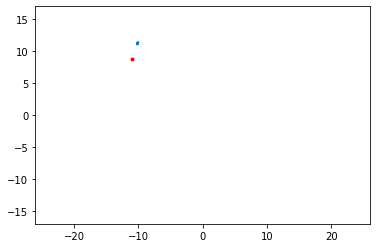

1


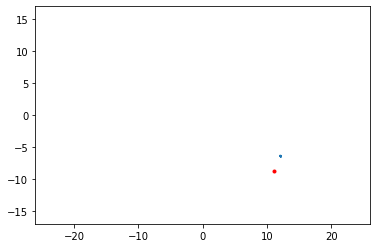

2


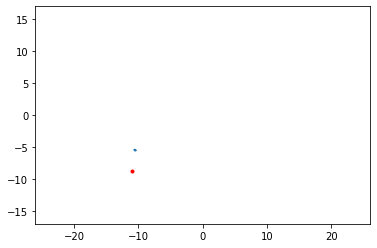

3


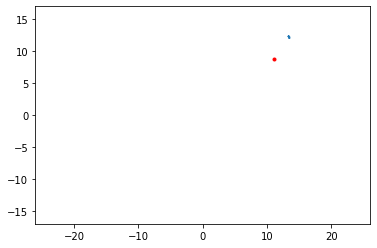

4


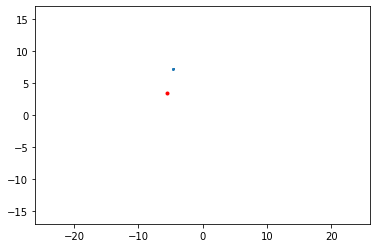

5


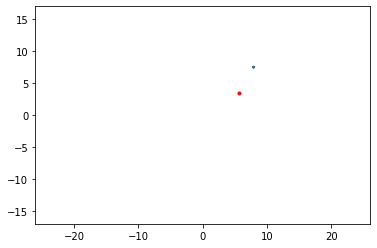

6


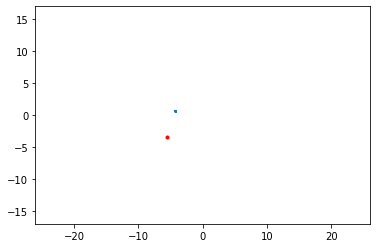

7


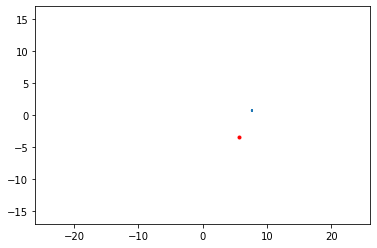

8


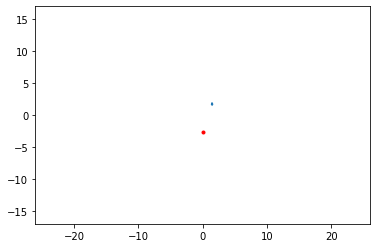

9


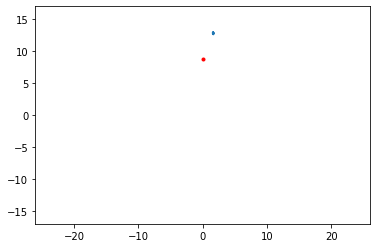

10


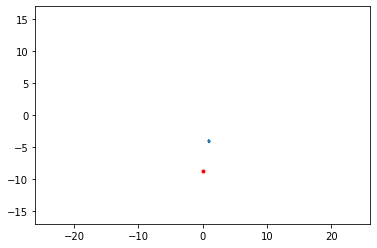

11


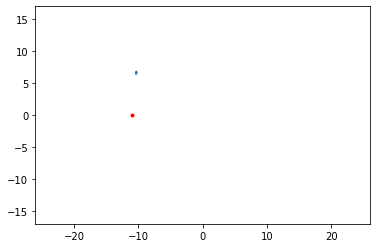

12


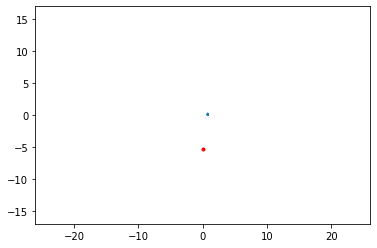

13


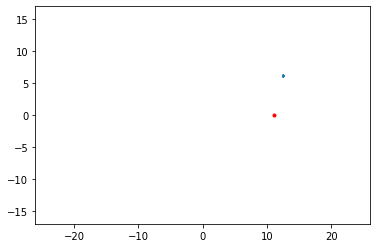

14


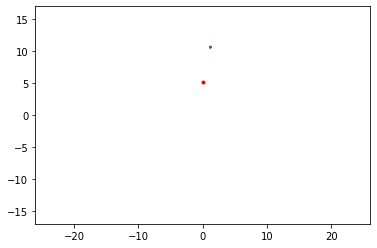

15


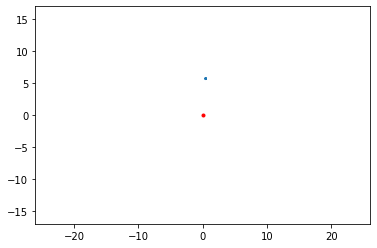

In [13]:
for frame in range(16):
    fig=plt
    fig.clf()
    fig.plot(gazeDataList[frame]["Azimuth"], gazeDataList[frame]["Elevation"])
    fig.plot(truePointAngles[frame][0], truePointAngles[frame][1], marker=".", color="red")
    fig.xlim(-26.05, 26.05)
    fig.ylim(-17, 17)
    print(frame)
    fig.show()

#### Plots the eye movement on single point 

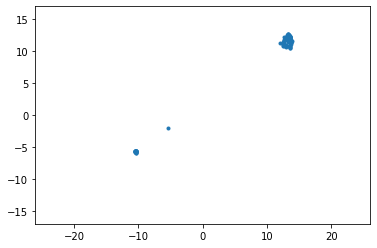

In [14]:
point = 3

plt.plot(stimulusPointData[point]["Azimuth"], stimulusPointData[point]["Elevation"], marker=".", ls="")
plt.xlim(-26.05, 26.05)
plt.ylim(-17, 17)
plt.show()